In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [7]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

# import umap
from sklearn.preprocessing import MinMaxScaler 

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.3.1'

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [10]:
from ood_detection_helper import *

In [11]:
LABELS = np.array(["Train", "CIFAR", "CelebA", "SVHN"])
colors = ["red", "blue", "green", "orange"]

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18

## Resuming from ckpt 8

In [13]:
model = load_model(inlier_name="cifar10", checkpoint=8,
                   save_path="/home/Developer/NCSN-TF2.0/saved_models/",
                   split="95,5"
                  )

(1, 32, 32, 3)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 32, 32, 128)  302848      conv2d[0][0]                     
                                                                 idx_sig

In [21]:
# with tf.device('CPU'):
#     celeb_test = get_train_test_data("celeb_a")[1]
#     celeb_test = celeb_test.shuffle(20)
# celeb_test_batches = [x for x in celeb_test][:10]

In [16]:
TEST_BATCH=512

@tf.function
def normalize(x):
    return x / 255

with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, data_dir="../../data",
                                shuffle_files=True,
                                split = ["train[:{}%]".format(95),
                                         "train[-{}%:]".format(5),
                                         "test"]
                               )
    cifar_train = tf.data.Dataset.from_tensor_slices(data_generators[0]['image'])
    cifar_train = cifar_train.map(normalize).batch(TEST_BATCH).take(2)
    
    cifar_val = tf.data.Dataset.from_tensor_slices(data_generators[1]["image"])
    cifar_val = cifar_val.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar_val = cifar_val.batch(TEST_BATCH).take(2)
    
    cifar_test = tf.data.Dataset.from_tensor_slices(data_generators[2]["image"])
    cifar_test = cifar_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar_test = cifar_test.batch(TEST_BATCH).take(2)
    
data_generators = tfds.load(name="svhn_cropped", batch_size=-1,
                            data_dir="../../data", shuffle_files=False)
svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
#     svhn_test = svhn_test.take(26000)
svhn_test = svhn_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
svhn_test = svhn_test.batch(TEST_BATCH).take(1)

In [31]:
def compute_weighted_scores(model, x_test):
    # Sigma Idx -> Score
    score_dict = []
    sigmas = utils.get_sigma_levels()
    final_logits = 0 #tf.zeros(logits_shape)
    progress_bar = tqdm(sigmas)
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits = []
        for x_batch in x_test:
#             x_batch += tf.random.normal(shape=x_batch.shape) * sigma
            idx_sigmas = tf.ones(x_batch.shape[0], dtype=tf.int32) * idx
            score = model([x_batch, idx_sigmas]) * sigma
            score = reduce_norm(score)
            _logits.append(score)
        score_dict.append(tf.identity(tf.concat(_logits, axis=0)))
    
    # N x L Matrix of score norms
    scores =  tf.squeeze(tf.stack(score_dict, axis=1))
    return scores

In [33]:
%%time
train_dist = compute_weighted_scores(model, cifar_train)
val_dist = compute_weighted_scores(model, cifar_val)
# test_dist = compute_weighted_scores(model, cifar_test)
svhn_dist = compute_weighted_scores(model, svhn_test)

Sigma: 0.0100: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

CPU times: user 24.9 s, sys: 26.6 s, total: 51.6 s
Wall time: 48.6 s


In [34]:
scores = {
    "train": train_dist,
    "test": val_dist,
    "svhn": svhn_dist
}

In [32]:
# noise_scores = {
#     "train": train_dist,
#     "test": val_dist,
#     "svhn": svhn_dist
# }

In [35]:
dfs=[]
sigma_levels = utils.get_sigma_levels()
for name, s in scores.items():
    _df = pd.DataFrame(s.numpy())
    _df["dataset"] = name
    dfs.append(_df.copy())
    
df = pd.concat(dfs)
df.columns = [*sigma_levels.numpy() , "dataset"]

melted = df.melt(id_vars=["dataset"], var_name="sigma", value_name="score")
melted

,dataset,sigma,score
0,train,1,28.851128
1,train,1,28.127842
2,train,1,30.021217
3,train,1,28.370186
4,train,1,30.169531
...,...,...,...
25595,svhn,0.01,38.687763
25596,svhn,0.01,39.131977
25597,svhn,0.01,39.012779
25598,svhn,0.01,36.735157


### Noise Perturbed

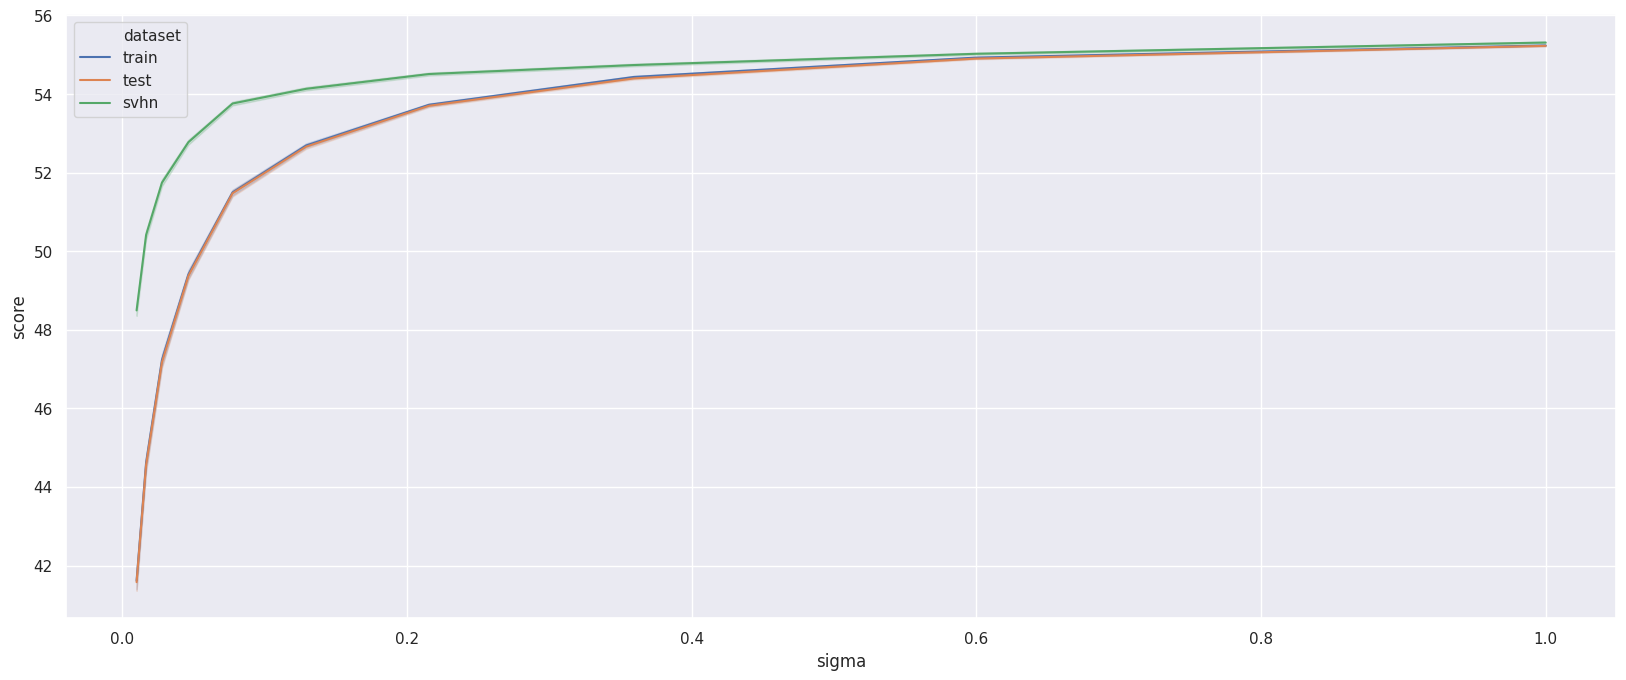

In [30]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
sns.set(style="darkgrid")

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="dataset", data=melted, err_style="band",
             ci=95, ax=ax, markers=True, dashes=False)

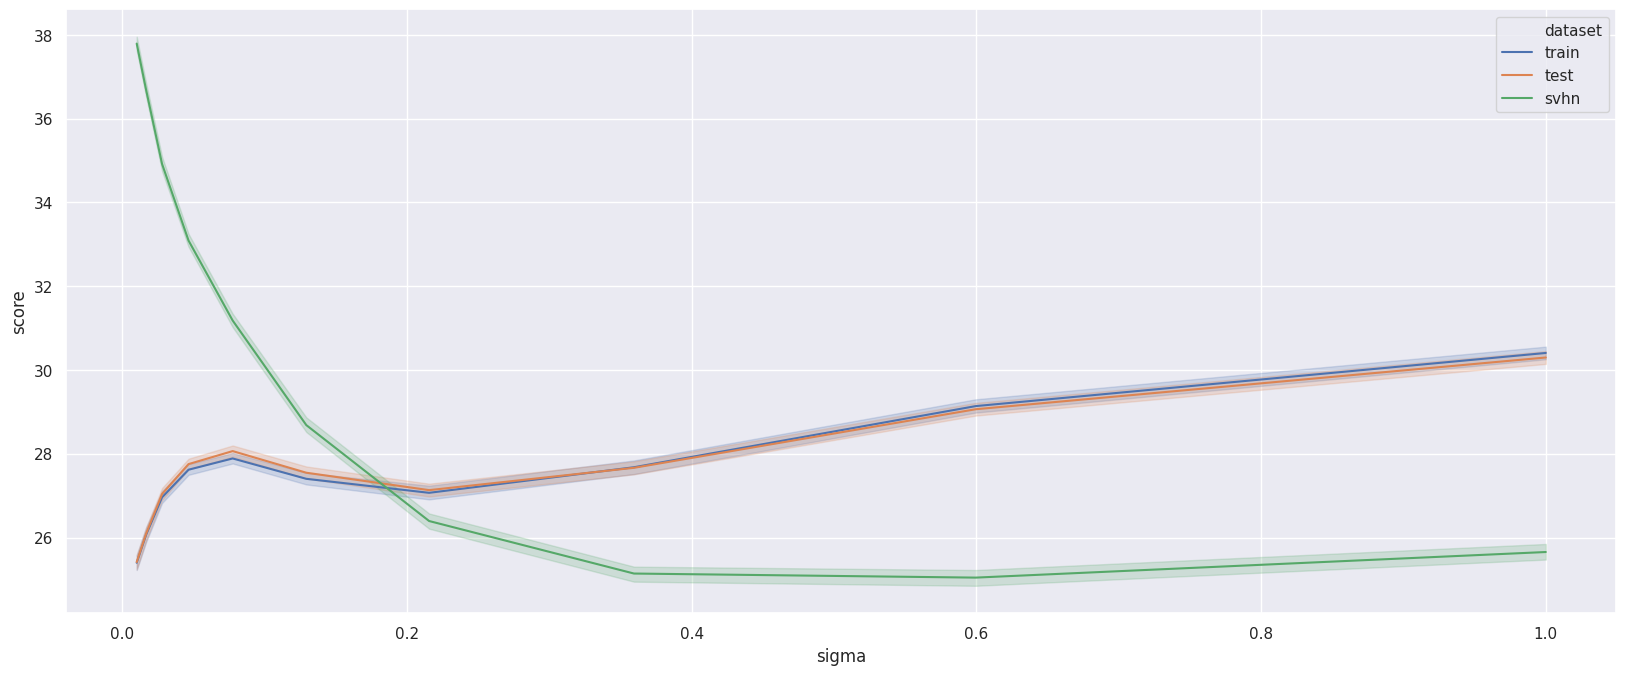

In [36]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="dataset", data=melted, err_style="band",
             ci=95, ax=ax, markers=True, dashes=False)

In [20]:
import pickle

with open("scores_cifar.p", "wb") as f:
    pickle.dump(scores, f)

In [28]:
np.logspace(-1, 1, 10)

array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ])

## Generating Samples

In [15]:
utils.get_savemodel_dir()

('saved_models/refinenet128_cifar10_L10_SH1e+00_SL1e-02/',
 'refinenet128_cifar10_L10_SH1e+00_SL1e-02')

In [16]:
save_dir, complete_model_name = utils.get_savemodel_dir() # "longleaf_models/baseline64_fashion_mnist_SL0.001", ""
model, optimizer, step, _, _ = utils.try_load_model(save_dir,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

(1, 32, 32, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 32, 32, 128)  302848      conv2d[0][0]                     
                                                                 idx_sigmas[0][

In [26]:
@tf.function(experimental_compile=True)
def reduce_norm(x):
    return tf.norm(tf.reshape(x, shape=(x.shape[0], -1)),
                   axis=1, ord="euclidean", keepdims=True)
    

### Getting Score Distributions

In [14]:
%%time

idx_sigmas = tf.ones(TEST_BATCH,dtype=tf.int32) * BEST_SIGMA_IDX

for cifar_, svhn_, celeb_ in zip(cifar_test_batches, svhn_test_batches, celeb_test_batches):
#     fashion_logits = model([fashion_, idx_sigmas])
    celeb_logits = model([celeb_, idx_sigmas])
    cifar_logits = model([cifar_, idx_sigmas])
    svhn_logits = model([svhn_, idx_sigmas])
    break

CPU times: user 2.5 s, sys: 5.31 s, total: 7.81 s
Wall time: 7.83 s


In [19]:
# L2-norm same as Frobenius
f_train_svhn_score = tf.norm(svhn_logits, axis=[1,2], ord="euclidean").numpy()
f_train_celeb_score = tf.norm(celeb_logits, axis=[1,2], ord="euclidean").numpy()
f_train_cifar_score = tf.norm(cifar_logits, axis=[1,2], ord="euclidean").numpy()

In [21]:
column_names = []

for c in ["R", "G", "B"]:
    for n in ["SVHN", "CIFAR"]:
        column_names.append(n+"_"+c)

df = pd.DataFrame(np.hstack((f_train_svhn_score[:,:],
                             f_train_cifar_score[:,:])),
             columns=column_names)
df.describe()

,SVHN_R,CIFAR_R,SVHN_G,CIFAR_G,SVHN_B,CIFAR_B
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2091.447510,2160.821533,2117.207275,1467.223267,1522.869263,1444.243164
std,104.943848,109.679222,129.982071,165.336823,191.037430,178.883255
min,1626.400269,1571.201660,1524.585327,1068.203491,781.238708,943.436462
25%,2032.936829,2095.143494,2035.452271,1346.425323,1389.768402,1307.623169
50%,2101.006836,2179.682983,2125.176392,1452.800659,1513.329773,1429.673218
75%,2162.370789,2239.328857,2205.301819,1584.920898,1652.075043,1562.658722
max,2339.859131,2485.538330,2501.125732,2050.310303,2103.208252,2209.054932


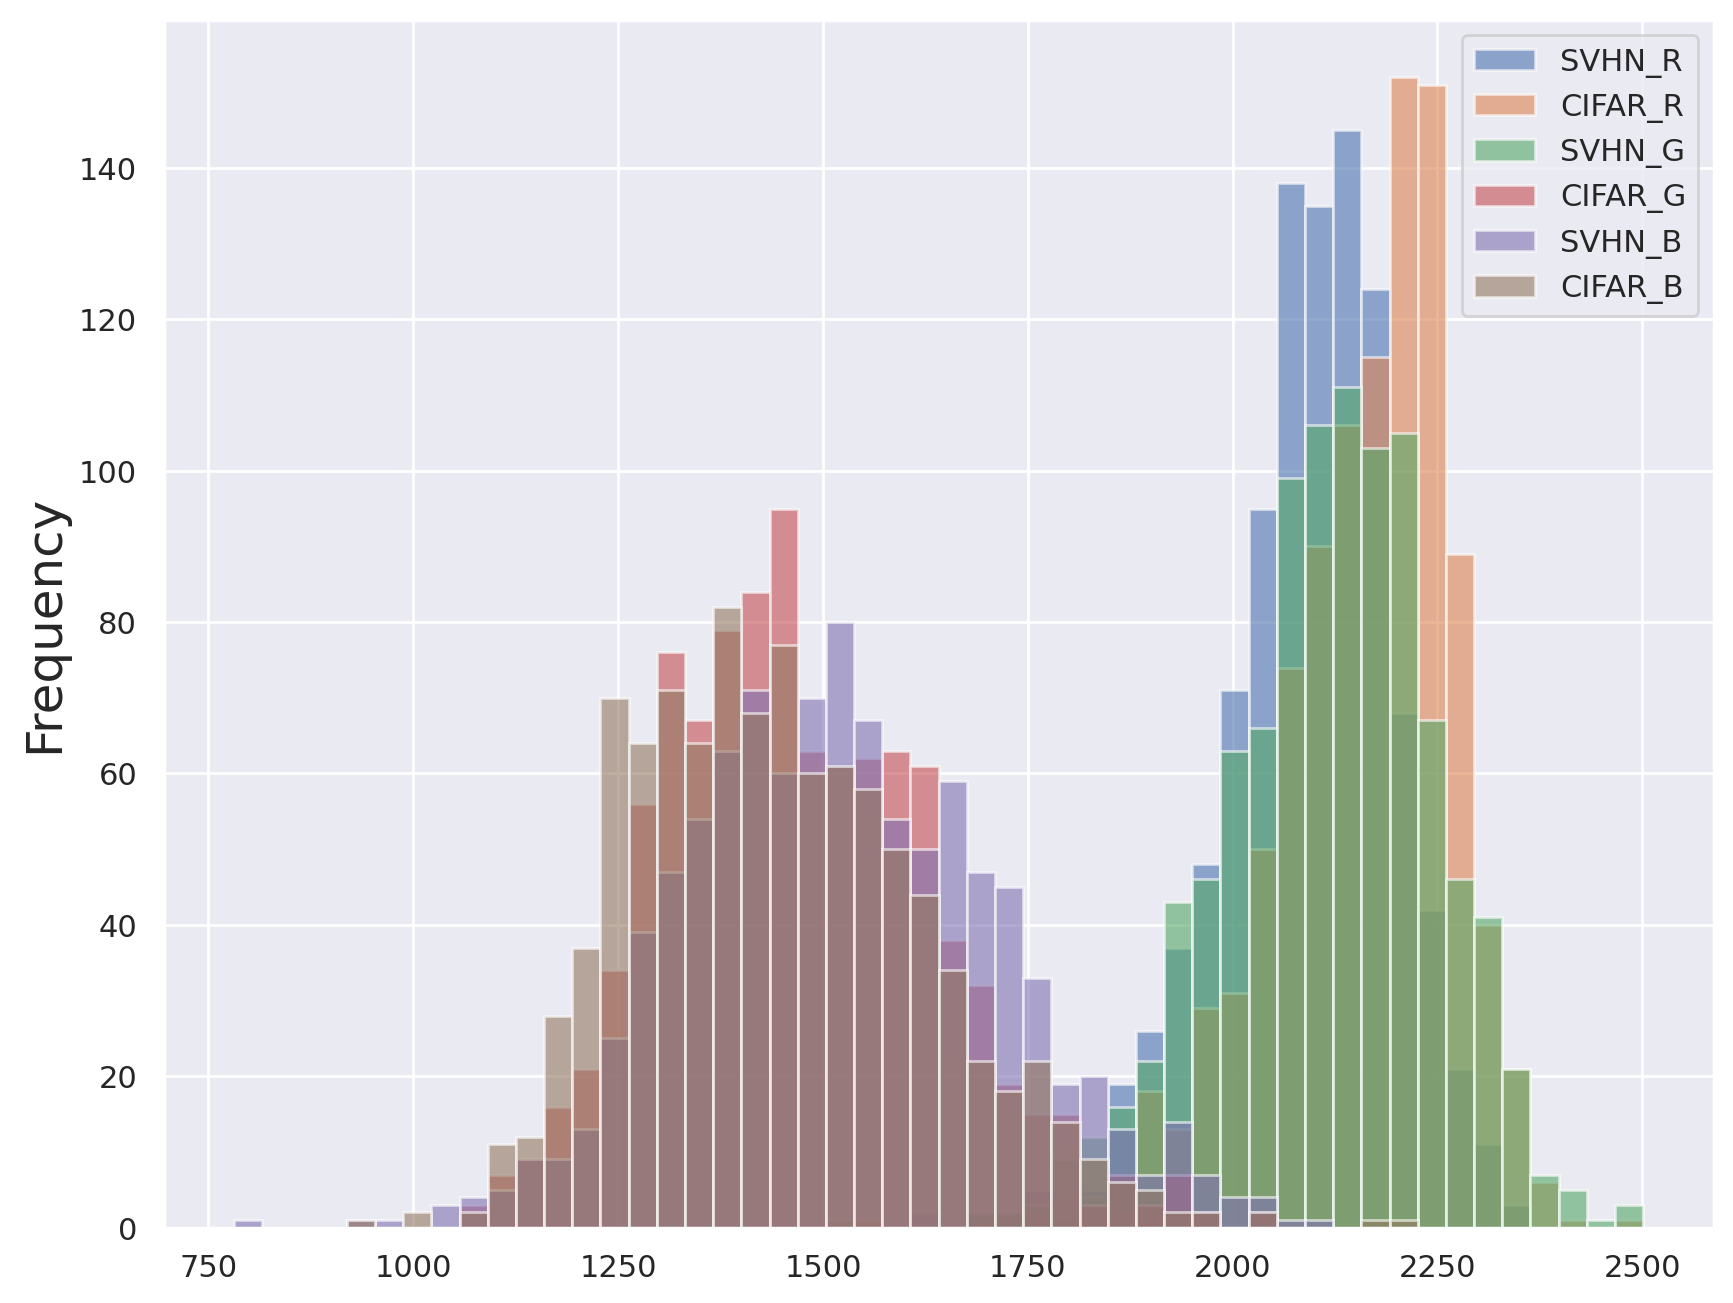

In [22]:
df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))

In [27]:
%%time
svhn_score = reduce_norm(svhn_logits).numpy()
celeb_score = reduce_norm(celeb_logits).numpy()
cifar_score = reduce_norm(cifar_logits).numpy()

CPU times: user 4.51 ms, sys: 16.2 ms, total: 20.7 ms
Wall time: 18.1 ms


In [28]:
svhn_score.shape

(1000, 1)

,SVHN,CelebA,CIFAR
count,1000.000000,1000.000000,1000.000000
mean,3679.054932,2809.675537,2562.604492
std,174.221664,162.842453,294.266327
min,2734.248291,2354.533936,1756.987671
25%,3571.356750,2698.172424,2342.063049
50%,3704.598755,2792.325562,2541.675049
75%,3801.698425,2901.046021,2768.678833
max,4110.201660,3390.010498,3538.035645


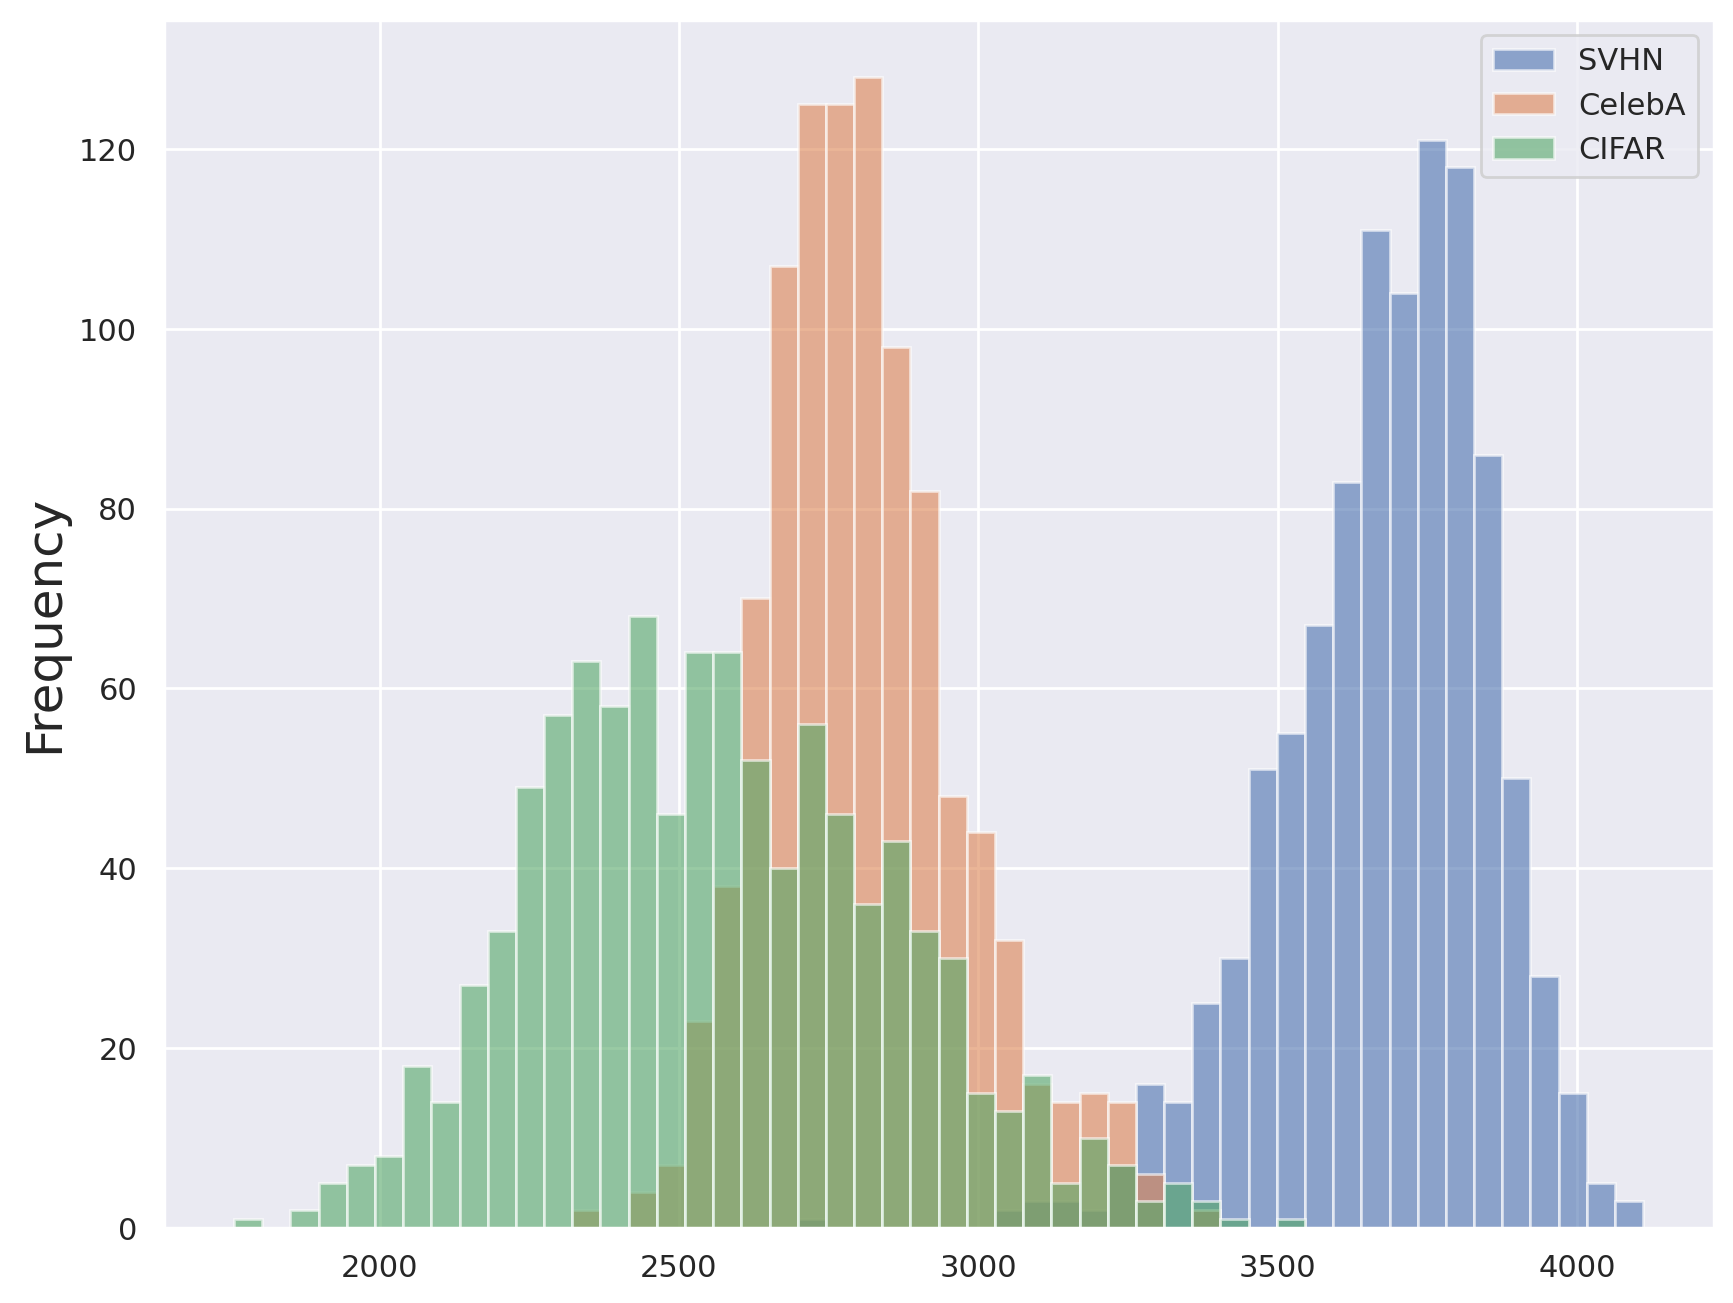

In [29]:
df = pd.DataFrame(np.hstack((svhn_score,
                            celeb_score,
                            cifar_score)),
                  columns=["SVHN", "CelebA", "CIFAR"])

df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))
df.describe()

### CIFAR vs SVHN

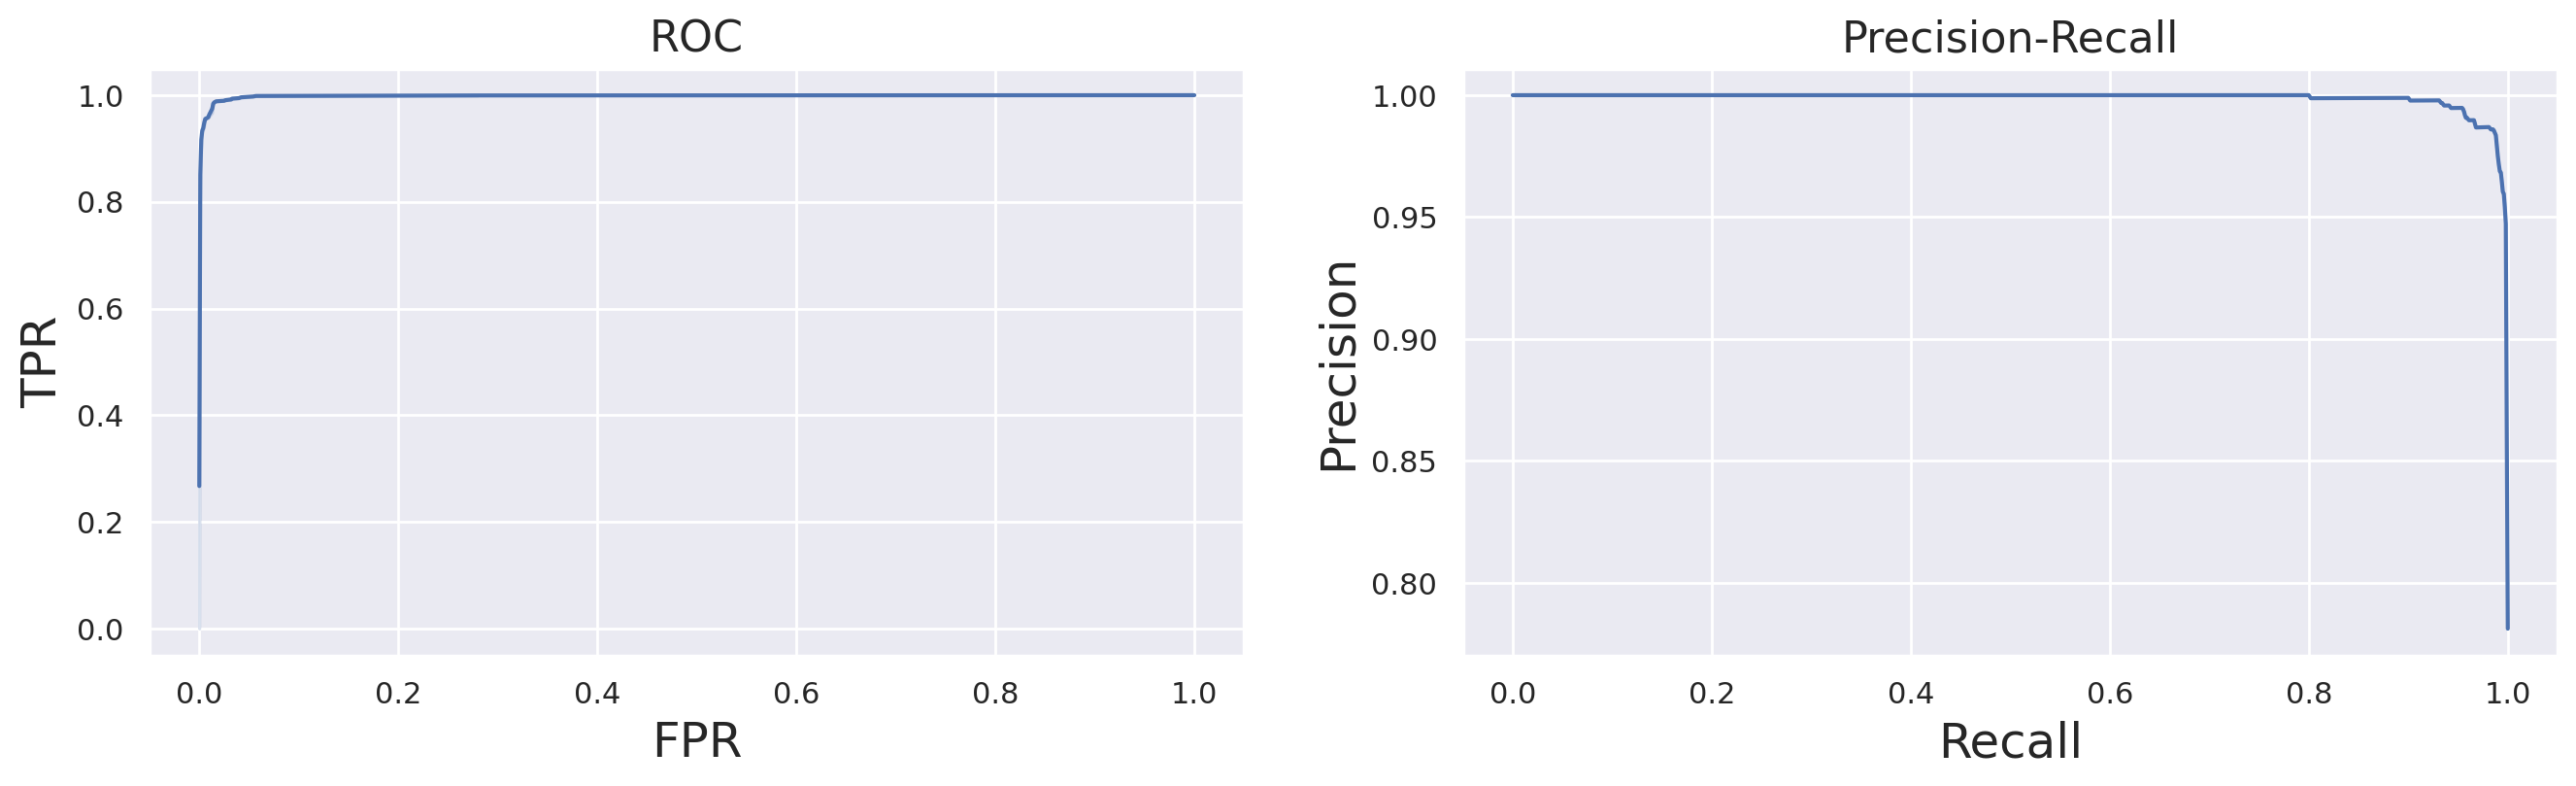

Inlier vs Outlier
----------------
ROC-AUC: 0.9987
PR-AUC: 0.9987
Avg Prec: 0.9987


In [31]:
metrics(cifar_score, svhn_score, plot=True, verbose=True)
plt.show()

### CIFAR vs CelebA

In [ ]:
metrics(cifar_score, celeb_score, plot=True, verbose=True)
plt.show()

# Using all norms

In [54]:
10*10000*32*32*3*4 // 1024**3

1

In [20]:
outlier_datasets = (celeb_test_batches, svhn_test_batches)

In [21]:
# %%time
# train_dist = compute_scores(cifar_train)

In [23]:
%%time
cifar_dist = compute_scores(cifar_test_batches)

Sigma: 0.0100: 100%|██████████| 10/10 [03:03<00:00, 18.33s/it]

CPU times: user 58.9 s, sys: 54.8 s, total: 1min 53s
Wall time: 3min 3s


In [24]:
%%time
outlier_dists = []
progress_bar = tqdm(zip(LABELS[2:], outlier_datasets))
for name, outlier in progress_bar:
    progress_bar.set_description(name)
    outlier_dists.append(compute_scores(outlier))

CelebA: : 0it [00:00, ?it/s]
Sigma: 0.0100: 100%|██████████| 10/10 [03:04<00:00, 18.41s/it]
SVHN: : 1it [03:04, 184.90s/it]  
Sigma: 0.0100: 100%|██████████| 10/10 [03:04<00:00, 18.43s/it]
SVHN: : 2it [06:10, 185.09s/it]

CPU times: user 1min 57s, sys: 1min 51s, total: 3min 49s
Wall time: 6min 10s


In [27]:
celeb_dist, svhn_dist = outlier_dists

In [37]:
# np.savez("scores.npz", celeba=celeb_dist, svhn=svhn_dist)

In [38]:
# L2-norm same as Frobenius
with tf.device("cpu"):
#     train_agg = tf.add_n([train_dist[x] * s for x, s in enumerate(SIGMAS)])
    inlier_agg = tf.add_n([cifar_dist[x] * s for x, s in enumerate(SIGMAS)])
    outlier_agg = tf.add_n([celeb_dist[x] * s for x,s in enumerate(SIGMAS)])
    outlier_agg_2 = tf.add_n([svhn_dist[x] * s for x,s in enumerate(SIGMAS)])

#     train_score = tf.reduce_mean(tf.norm(train_agg, axis=[1,2]), axis=1).numpy()[:, np.newaxis]
    cifar_score = reduce_norm(inlier_agg).numpy()
    celeb_score = reduce_norm(outlier_agg).numpy()
    svhn_score = reduce_norm(outlier_agg_2).numpy()

In [39]:
outlier_agg.shape

TensorShape([10000, 32, 32, 3])

In [40]:
df = pd.DataFrame(np.hstack((
#                 train_score[-len(cifar_score):],
                cifar_score[:TEST_BATCH*9],
                celeb_score[:TEST_BATCH*9],
                svhn_score[:TEST_BATCH*9])),
 columns=["CIFAR-Test", "CelebA", "SVHN"])
df.describe()

,CIFAR-Test,CelebA,SVHN
count,9000.000000,9000.000000,9000.000000
mean,248.180389,266.155396,283.242737
std,18.532169,10.251641,19.505890
min,167.767410,207.599884,208.281769
25%,236.002895,259.518959,270.112732
50%,247.119240,266.294174,284.383499
75%,258.665184,272.835663,297.357849
max,341.737213,312.795105,347.998932


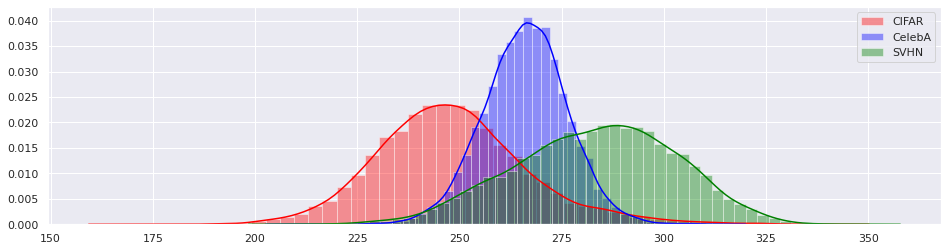

In [41]:
fig, ax = plt.subplots(1,1, figsize=(16,4))



for idx, sc in enumerate([cifar_score,
                          celeb_score,
                          svhn_score]):

    sns.distplot(sc, label=LABELS[idx+1], color=colors[idx], ax=ax)
plt.legend()
plt.show()

**CIFAR vs SVHN**

In [49]:
metrics(cifar_score, svhn_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9000
PR-AUC: 0.8877
Avg Prec: 0.8877


**CIFAR vs CelebA**

In [50]:
metrics(cifar_score, celeb_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.8159
PR-AUC: 0.7118
Avg Prec: 0.7118


## Train Data = L2-norm(Pixel Scores)

In [16]:
# #### %%time
# train_data, test_data = [], []
# outlier_data_1, outlier_data_2 = [], [] 

# for x, s in enumerate(SIGMAS):
# #     train_data.append(tf.norm(fashion_train_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
#     test_data.append(reduce_norm(cifar_dist[x] * s).numpy())
#     outlier_data_1.append(reduce_norm(celeb_dist[x] * s).numpy())
#     outlier_data_2.append(reduce_norm(svhn_dist[x] * s).numpy())
    
# # train_data = np.concatenate(train_data, axis=1)
# test_data = np.concatenate(test_data, axis=1)
# outlier_data_1 = np.concatenate(outlier_data_1, axis=1)
# outlier_data_2 = np.concatenate(outlier_data_2, axis=1)

# # Shapes
# shapes = [test_data.shape, outlier_data_1.shape, outlier_data_2.shape]
# print(shapes)

# X_train, X_test =  test_data[:9000], test_data[9000:]

# # import pickle

# # with open("scores.p", "wb") as f:
# #     pickle.dump({
# #         "cifar": test_data,
# #         "celeba":outlier_data_1,
# #         "svhn": outlier_data_2
# #     }, f)

In [8]:
from ood_detection_helper import *

In [6]:
with open("scores.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['cifar', 'celeba', 'svhn'])

In [7]:
test_data = score_dict["cifar"]
outlier_data_1 = score_dict["celeba"]
outlier_data_2 = score_dict["svhn"]

In [12]:
# Shapes
shapes = [test_data.shape, outlier_data_1.shape, outlier_data_2.shape]

samples = np.concatenate((test_data, outlier_data_1, outlier_data_2))

labels = np.concatenate((np.zeros(test_data.shape[0]),
                         np.ones(outlier_data_1.shape[0]),
                         2*np.ones(outlier_data_2.shape[0])))

captions = np.concatenate([[LABELS[idx]]*shapes[idx-1][0] for idx in range(1,4)])

### Score Norms

In [13]:
samples_train = np.concatenate((test_data[:9000], outlier_data_1[:9000], outlier_data_2[:9000]))
samples_test  = np.concatenate((test_data[9000:], outlier_data_1[9000:], outlier_data_2[9000:]))

samples_train.shape

(27000, 10)

In [14]:
# # from ood_detection_helper import ood_metrics

# def ood_metrics(inlier_score, outlier_score, plot=False, verbose=False, 
#                 names=["Inlier", "Outlier"]):
#     import numpy as np
#     import seaborn as sns
#     from sklearn.metrics import roc_curve
#     from sklearn.metrics import classification_report, average_precision_score
#     from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    

#     y_true = np.concatenate((np.zeros(len(inlier_score)),
#                              np.ones(len(outlier_score))))
#     y_scores = np.concatenate((inlier_score, outlier_score))
    
#     prec_in, rec_in, _ = precision_recall_curve(y_true, y_scores)

#     # Outliers are treated as "positive" class 
#     # i.e label 1 is now label 0
#     prec_out, rec_out, _ = precision_recall_curve((y_true==0), -y_scores)

#     fpr, tpr, thresholds = roc_curve(y_true, y_scores, drop_intermediate=False)
#     tpr95_idx = np.where(np.isclose(tpr,0.95))[0][0]
#     tpr80_idx = np.where(np.isclose(tpr,0.8))[0][0]

#     metrics = dict(
#         roc_auc = roc_auc_score(y_true,y_scores),
#         fpr_tpr95 = fpr[tpr95_idx],
#         fpr_tpr80 = fpr[tpr80_idx],
#         pr_auc_in = auc(rec_in, prec_in),
#         pr_auc_out = auc(rec_out, prec_out),
#         ap = average_precision_score(y_true,y_scores)
#     )
    
#     if plot:    
    
#         fig, axs = plt.subplots(1,2, figsize=(16,4))
#         fpr, tpr, thresholds = roc_curve(y_true, y_scores, drop_intermediate=True)
#         sns.lineplot(fpr, tpr, ax=axs[0])
#         axs[0].set(
#             xlabel="FPR", ylabel="TPR", title="ROC", ylim=(-0.05, 1.05)
#         )

#         sns.lineplot(rec_in, prec_in, ax=axs[1], label="PR-In")
#         sns.lineplot(rec_out, prec_out, ax=axs[1], label="PR-Out")
#         axs[1].set(
#             xlabel="Recall", ylabel="Precision", title="Precision-Recall", ylim=(-0.05, 1.05)
#         )
#         fig.suptitle("{} vs {}".format(*names), fontsize=20)
#         plt.show()
#         plt.close()
    
#     if verbose:
#         print("{} vs {}".format(*names))
#         print("----------------")
#         print("ROC-AUC: {:.4f}".format(metrics["roc_auc"]))
#         print("PR-AUC (In/Out): {:.4f} / {:.4f}".format(metrics["pr_auc_in"], metrics["pr_auc_out"]))
#         print("FPR (95% TPR) Prec: {:.4f}".format(metrics["fpr_tpr95"]))
        
#     return metrics

In [113]:
def evaluate_model(train_score, test_score, outlier_score, outlier_score_2):
    fig, axs = plt.subplots(2,1, figsize=(16,8))

    sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
    sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
    sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
    sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

    sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
    sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

    axs[0].legend()
    axs[1].legend()
    plt.show()
    
    ood_metrics(-test_score, -outlier_score_2, names=(LABELS[1], LABELS[3]),
                plot=False, verbose=True)
    print()
    ood_metrics(-test_score, -outlier_score, names=(LABELS[1], LABELS[2]),
                plot=False, verbose=True)
    return

## GMM

In [25]:
X_train, X_test =  test_data[:9000], test_data[9000:]
outlier_train = outlier_data_1[:9000], outlier_data_2[:9000]
outlier_test = outlier_data_1[9000:], outlier_data_2[9000:]

In [29]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def train_gmm_likelihood(X_train, components_range=range(2,21,2), verbose=False):
    
    
    gmm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("GMM", GaussianMixture())
    ])

    param_grid = dict(GMM__n_components = components_range,
                      GMM__covariance_type = ['full']) # Full always performs best 

    grid = GridSearchCV(estimator=gmm_clf,
                        param_grid=param_grid,
                        cv=10, n_jobs=10,
                        verbose=1)

    grid_result = grid.fit(X_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    if verbose:
        print("-----"*15)
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
        plt.plot([p["GMM__n_components"] for p in params], means)

    
    best_gmm_clf = gmm_clf.set_params(**grid.best_params_)
    best_gmm_clf.fit(X_train)
    
    return best_gmm_clf

def evaluate_GMM(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train)
    
    test_score = gmm_clf.score_samples(X_test)
    outlier_score = gmm_clf.score_samples(outlier_train[0])
    outlier_score_2 = gmm_clf.score_samples(outlier_train[1])
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

## Best Likelihood

In [18]:
%time best_gmm_clf = train_gmm_likelihood(X_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   25.5s finished


Best: 2.354901 using {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
CPU times: user 3min 23s, sys: 3min 10s, total: 6min 33s
Wall time: 33.9 s


In [19]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_test[0])))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_test[1])))

Training Likelihood: 2.488
CIFAR Likelihood: 2.493
CelebA Likelihood: 0.593
SVHN Likelihood: -6.540


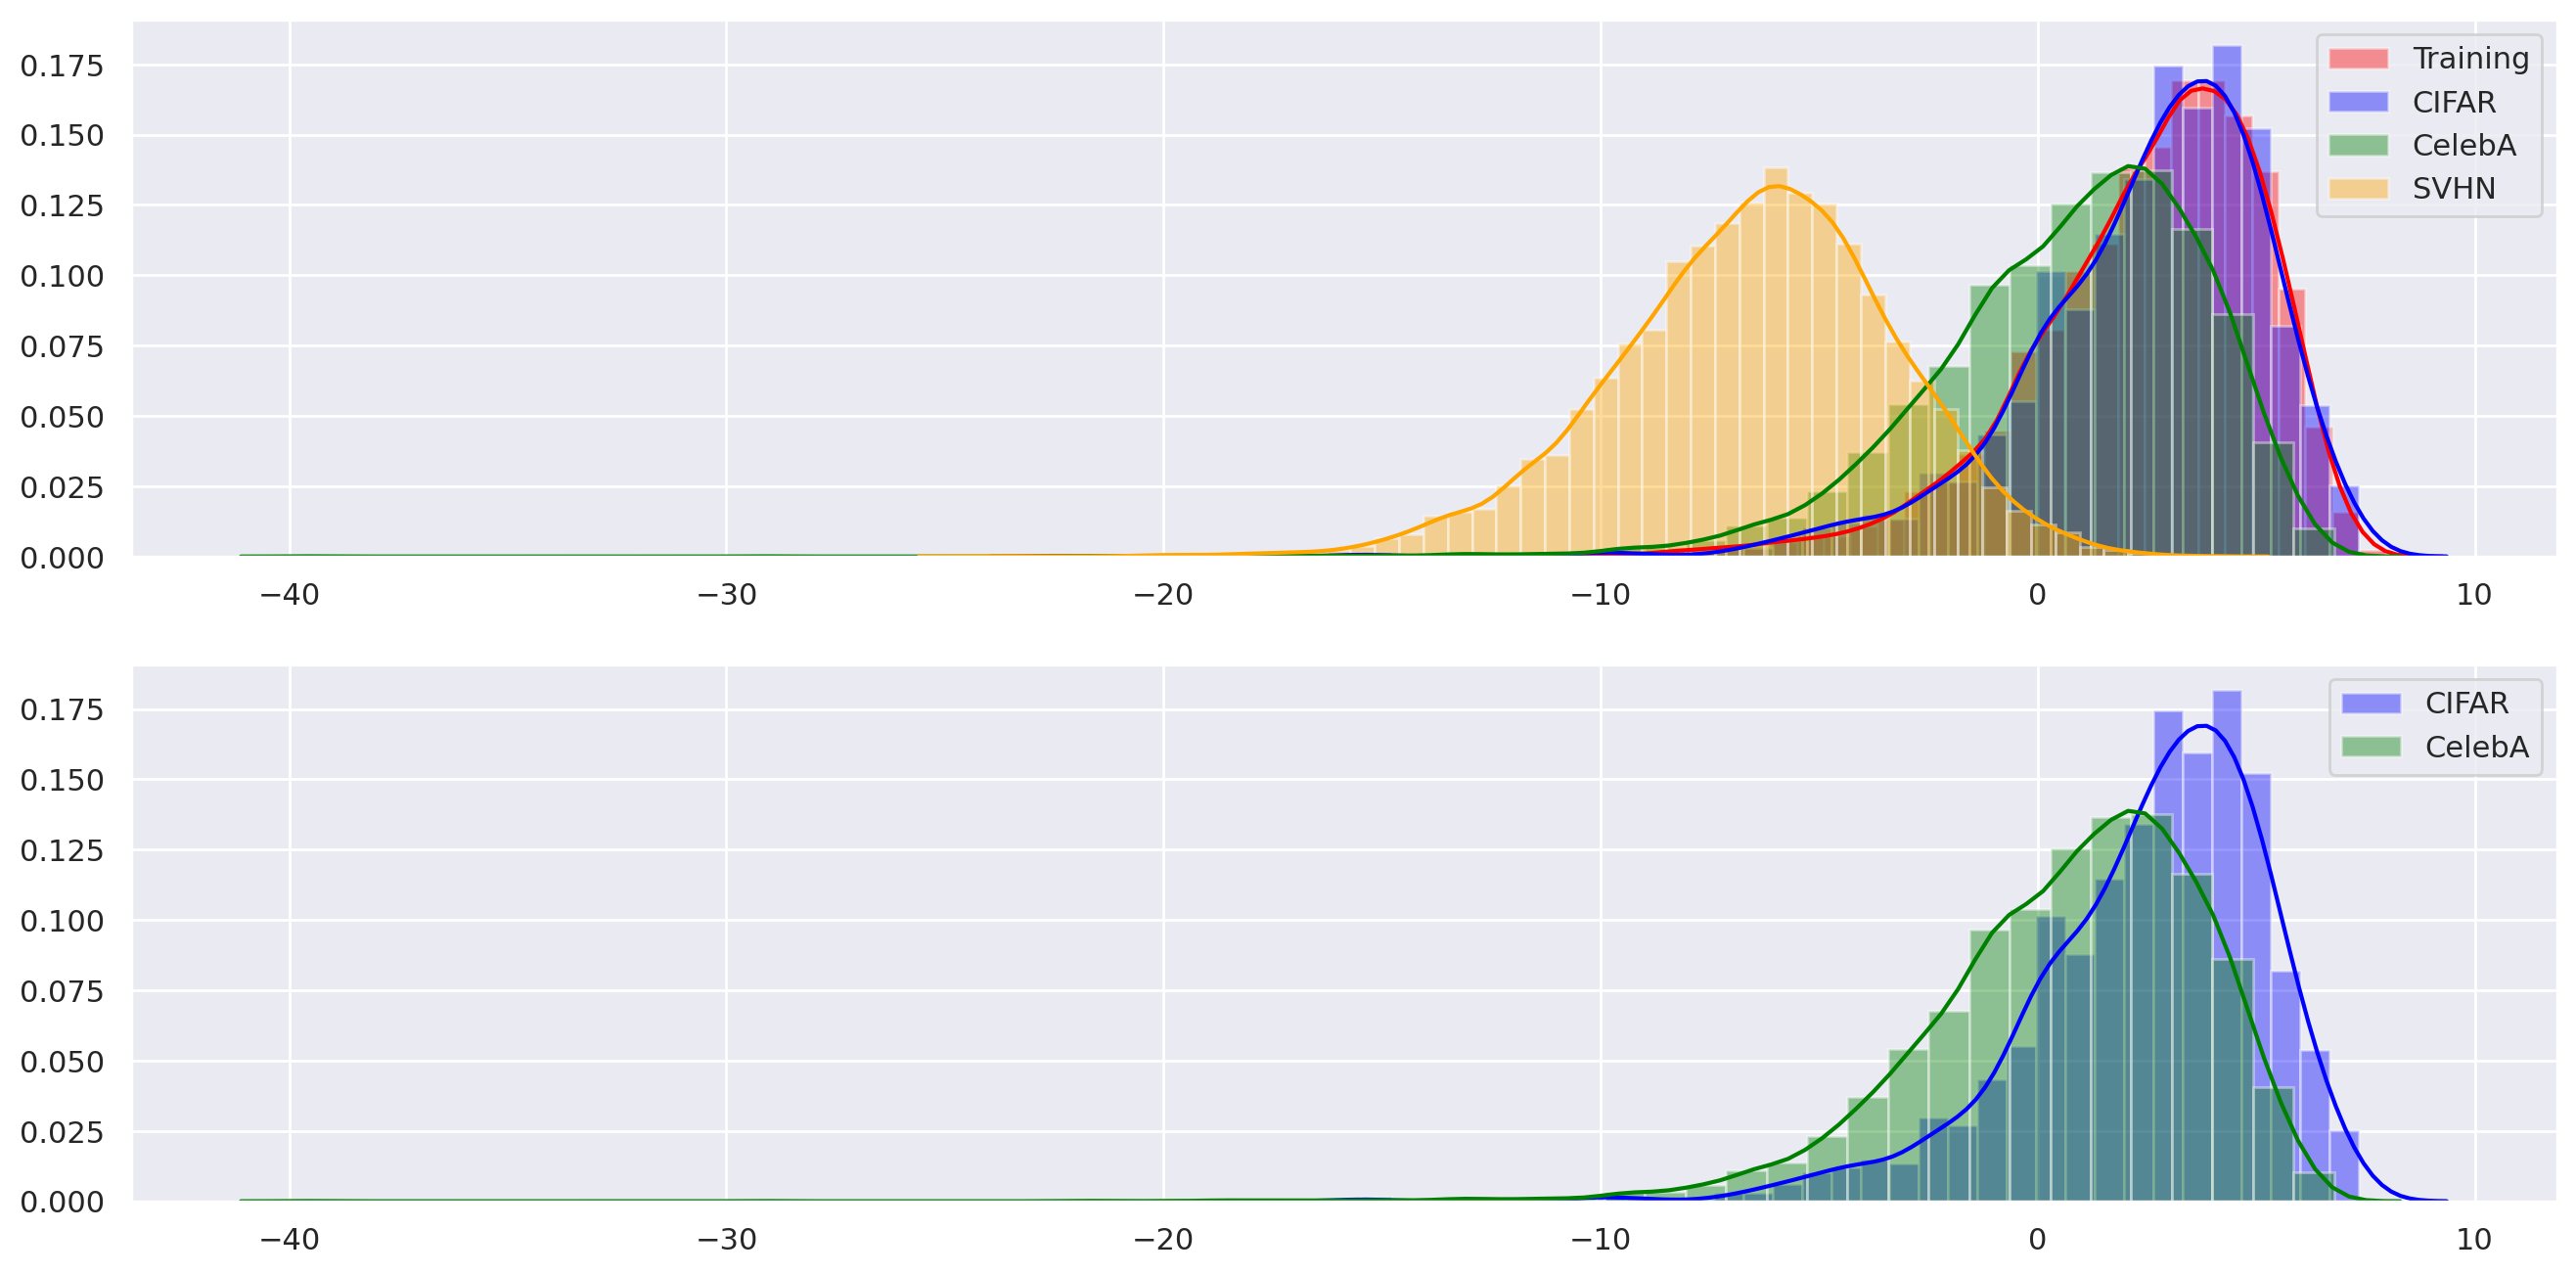

CIFAR vs SVHN
----------------
ROC-AUC: 0.9794
PR-AUC (In/Out): 0.9970 / 0.9222
FPR (95% TPR) Prec: 0.0790

CIFAR vs CelebA
----------------
ROC-AUC: 0.6807
PR-AUC (In/Out): 0.9487 / 0.2065
FPR (95% TPR) Prec: 0.8220


In [22]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

evaluate_model(train_score, test_score, outlier_score, outlier_score_2, labels=LABELS)

### AUC-based exploration

In [43]:
# %%time


# with ThreadPoolExecutor(max_workers = 4) as exc:
#     result = list(exc.map(evaluate_GMM, component_range))

In [ ]:
%%time

max_n_component = 50
component_range = range(2, max_n_component+1, 2)

result = [evaluate_GMM(n) for n in component_range]
result = np.array(result)

Best -> n=12: 0.832 


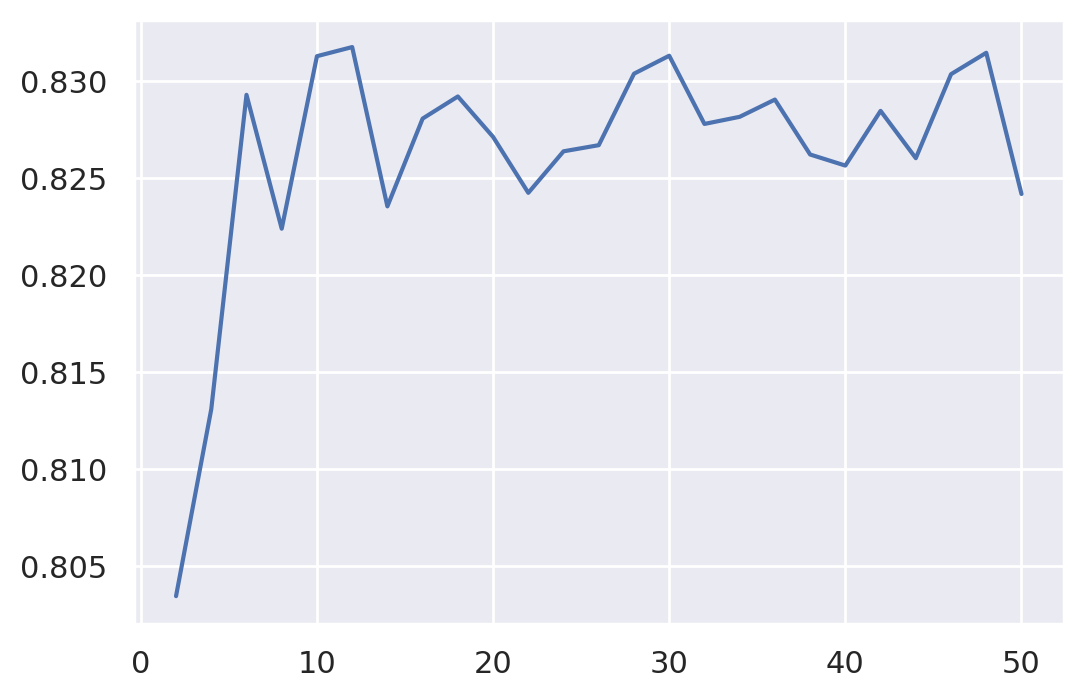

In [50]:
plt.plot(component_range, result)

print("Best -> n={}: {:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [51]:
best_gmm_clf = Pipeline([
#     ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**{"GMM__n_components":component_range[np.argmax(result)]})

best_gmm_clf.fit(X_train)

Pipeline(steps=[('GMM', GaussianMixture(n_components=12))])

In [52]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_data_2)))

Training Likelihood: -6.230
CIFAR Likelihood: -6.235
CelebA Likelihood: -7.991
SVHN Likelihood: -14.696


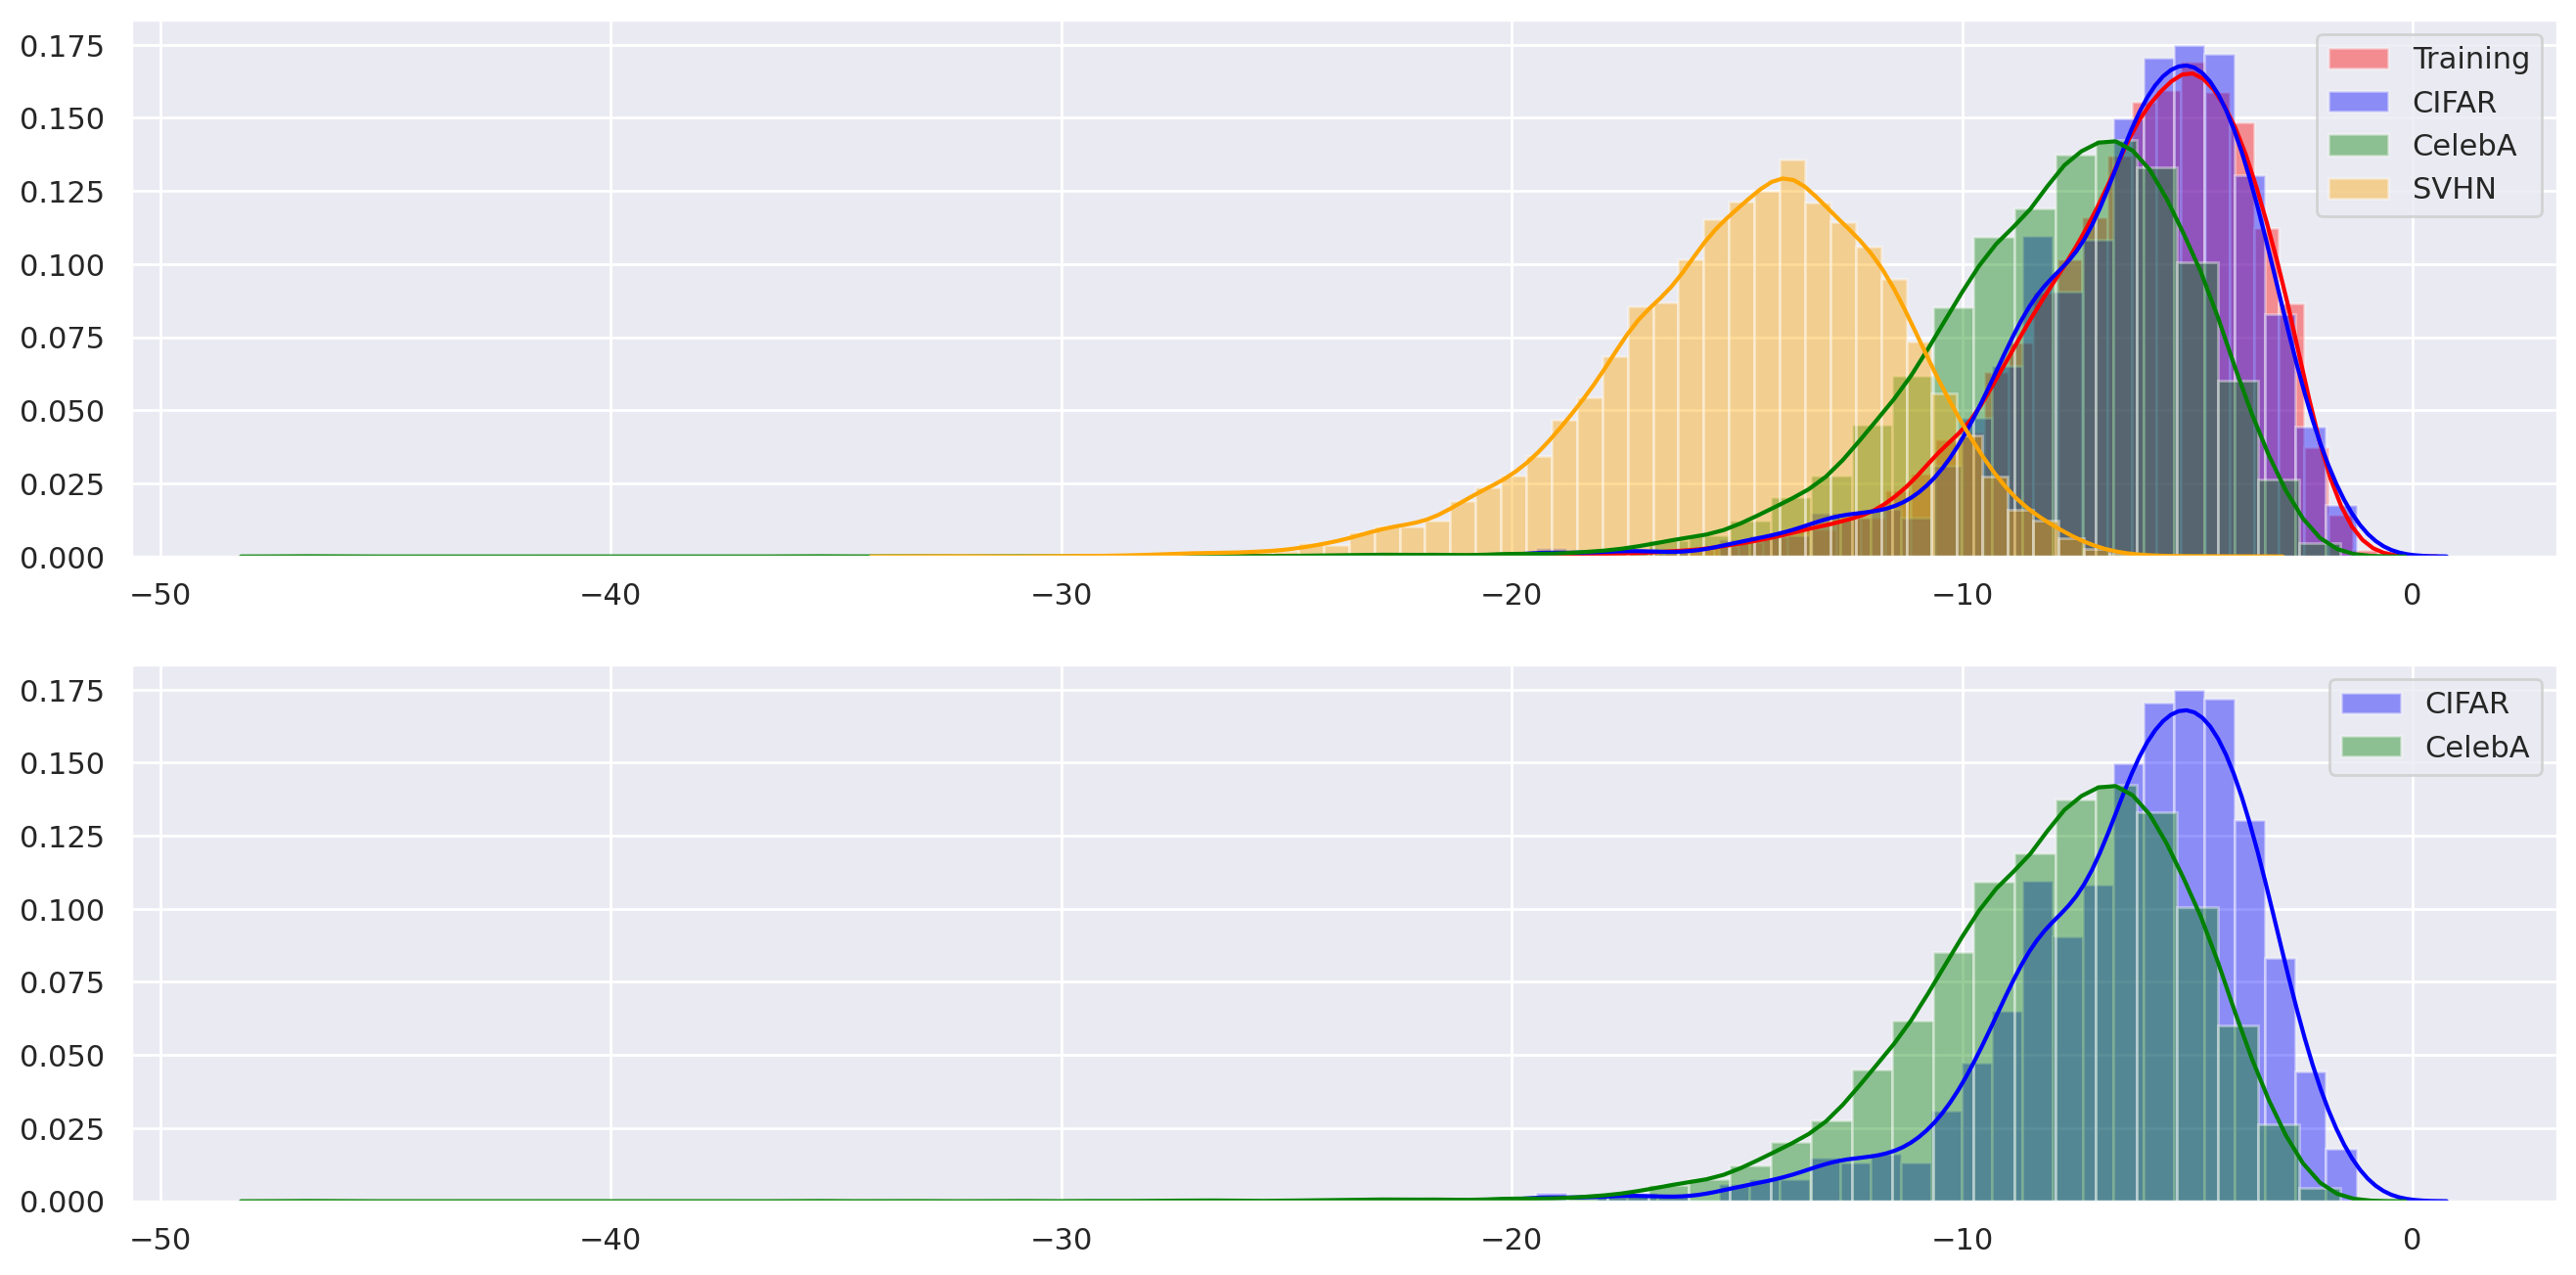

CIFAR vs SVHN
----------------
ROC-AUC: 0.9745
PR-AUC (In/Out): 0.9964 / 0.9127
FPR (95% TPR) Prec: 0.0810

CIFAR vs CelebA
----------------
ROC-AUC: 0.6814
PR-AUC (In/Out): 0.9480 / 0.2002
FPR (95% TPR) Prec: 0.8190


In [53]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

evaluate_model(train_score, test_score, outlier_score, outlier_score_2, labels=LABELS)

### Flow Models

In [41]:
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [42]:
X_train.shape

(9000, 10)

In [43]:
scaler = StandardScaler()
s_X_train = scaler.fit_transform(X_train)

In [44]:
# Density estimation with MADE.
n = X_train.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[256, 256], activation="relu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob)

batch_size = 64
epochs = 500
history = model.fit(
    x=s_X_train,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Epoch 1/500
140/140 [==============================] - 1s 5ms/step - loss: 14.1756
Epoch 2/500
140/140 [==============================] - 1s 4ms/step - loss: 14.0703
Epoch 3/500
140/140 [==============================] - 1s 4ms/step - loss: 14.0032
Epoch 4/500
140/140 [==============================] - 1s 4ms/step - loss: 13.9129
Epoch 5/500
140/140 [==============================] - 1s 4ms/step - loss: 13.8485
Epoch 6/500
140/140 [==============================] - 1s 4ms/step - loss: 13.7653
Epoch 7/500
140/140 [==============================] - 1s 4ms/step - loss: 13.7037
Epoch 8/500
140/140 [==============================] - 1s 4ms/step - loss: 13.5778
Epoch 9/500
140/140 [==============================] - 1s 5ms/step - loss: 13.4808
Epoch 10/500
140/140 [==============================] - 1s 5ms/step - loss: 13.3947
Epoch 11/500
140/140 [============================

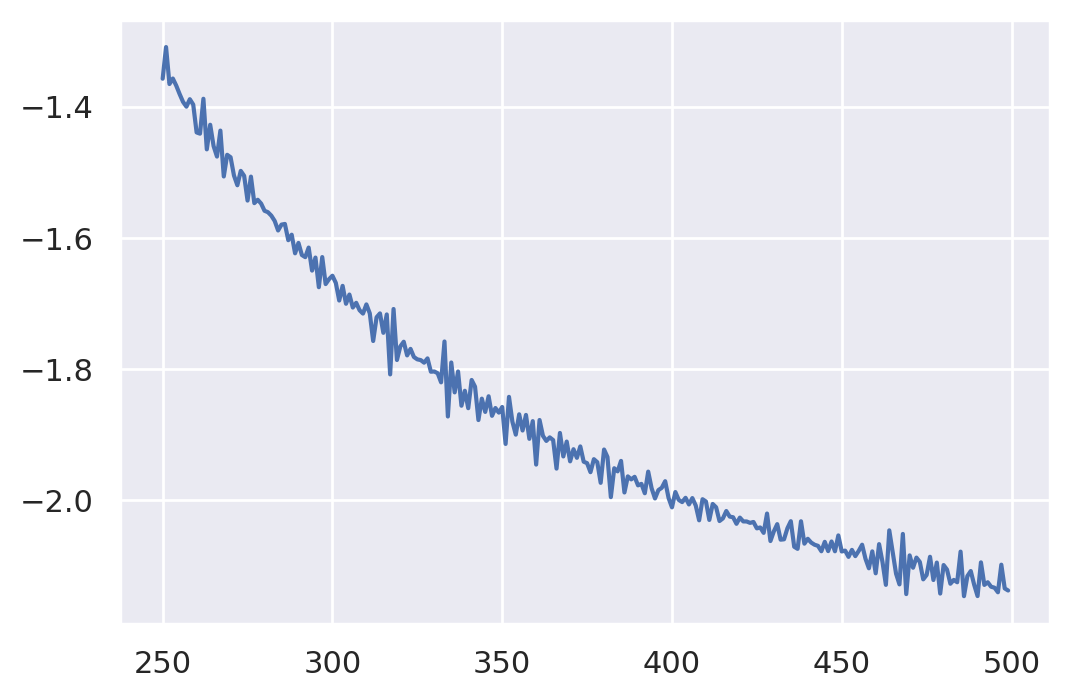

In [45]:
start_idx=250
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

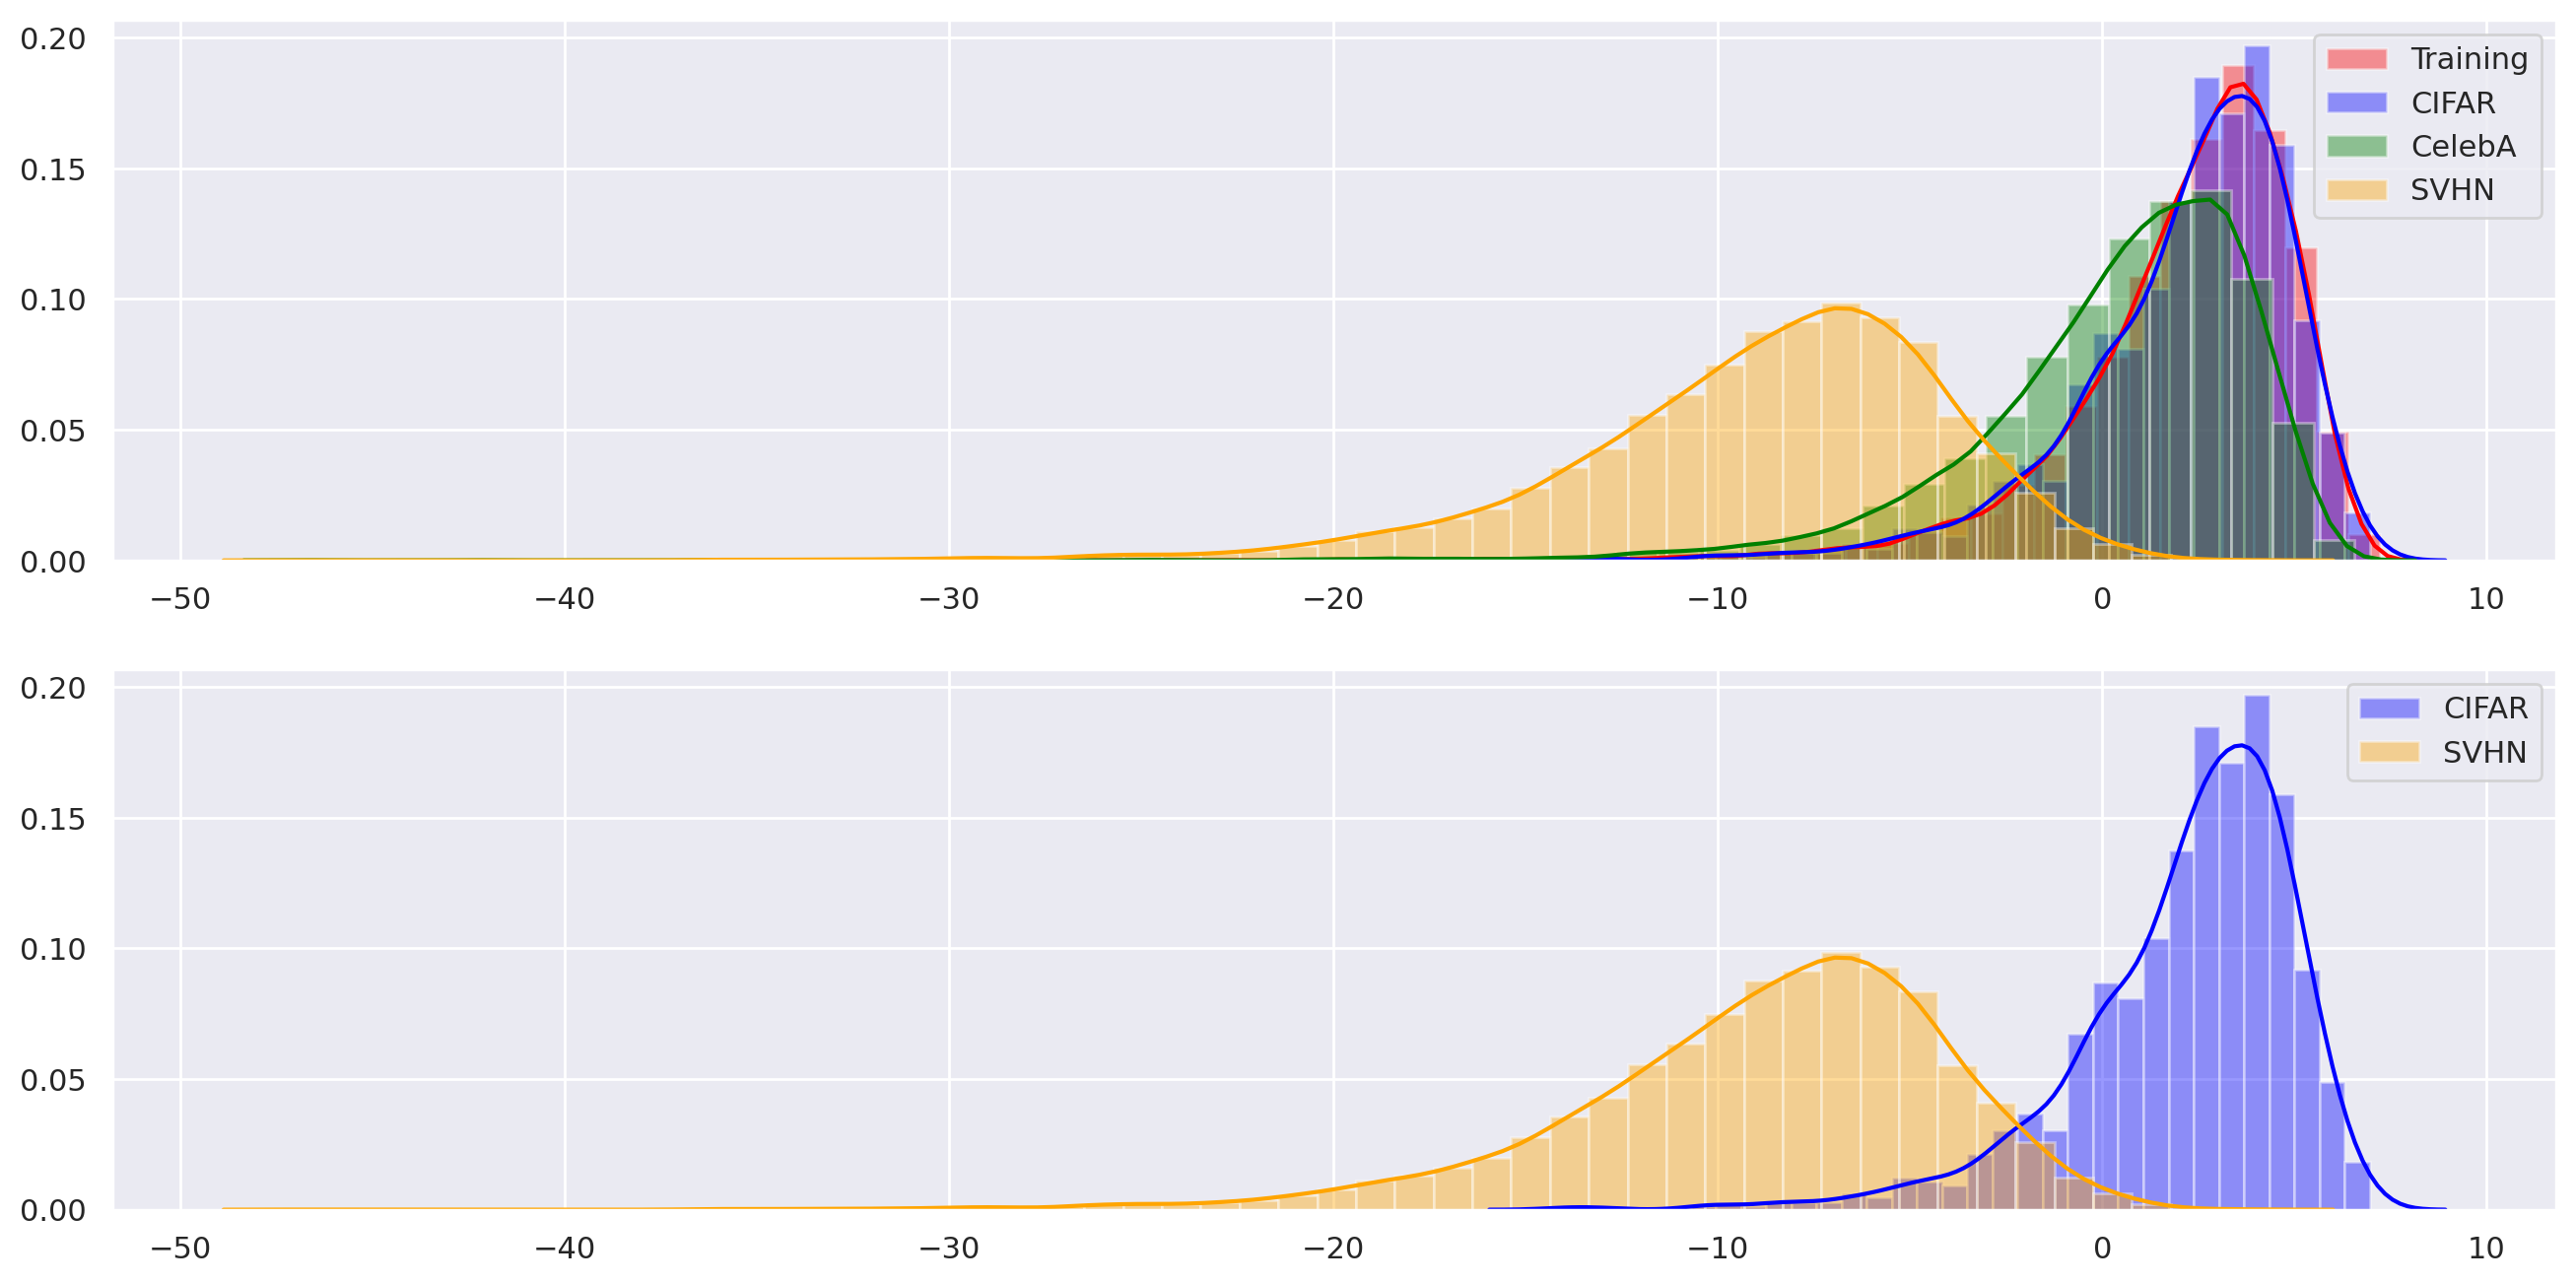

CPU times: user 1.85 s, sys: 109 ms, total: 1.95 s
Wall time: 1.95 s


In [48]:
%%time
train_score = distribution.log_prob(scaler.transform(X_train), dtype=np.float32).numpy()
test_score = distribution.log_prob(scaler.transform(X_test), dtype=np.float32).numpy()
outlier_score = distribution.log_prob(scaler.transform(outlier_data_1), dtype=np.float32).numpy()
outlier_score_2 = distribution.log_prob(scaler.transform(outlier_data_2), dtype=np.float32).numpy()

fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

In [49]:
ood_metrics(-test_score, -outlier_score_2, names=(LABELS[1], LABELS[3]),
                plot=False, verbose=True)
print()
ood_metrics(-test_score, -outlier_score, names=(LABELS[1], LABELS[2]),
            plot=False, verbose=True)

CIFAR vs SVHN
----------------
ROC-AUC: 0.9822
PR-AUC (In/Out): 0.9977 / 0.9317
FPR (95% TPR) Prec: 0.0680

CIFAR vs CelebA
----------------
ROC-AUC: 0.6699
PR-AUC (In/Out): 0.9475 / 0.1915
FPR (95% TPR) Prec: 0.8390


{'roc_auc': 0.6699149,
 'fpr_tpr95': 0.839,
 'fpr_tpr80': 0.588,
 'pr_auc_in': 0.9475172970507985,
 'pr_auc_out': 0.19154010922135284,
 'ap': 0.9475260204726026}

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def evaluate_GMM_emb(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train_embedding)
    
    test_score = gmm_clf.score_samples(X_test_embedding)
    outlier_score = gmm_clf.score_samples(outlier_train_embedding_1)
    outlier_score_2 = gmm_clf.score_samples(outlier_train_embedding_2)
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

In [ ]:
%%time

max_n_component = 25
component_range = range(1, max_n_component+1, 1)

with ThreadPoolExecutor(max_workers = 4) as exc:
    result = list(exc.map(evaluate_GMM, component_range))
    
result = np.array(result)

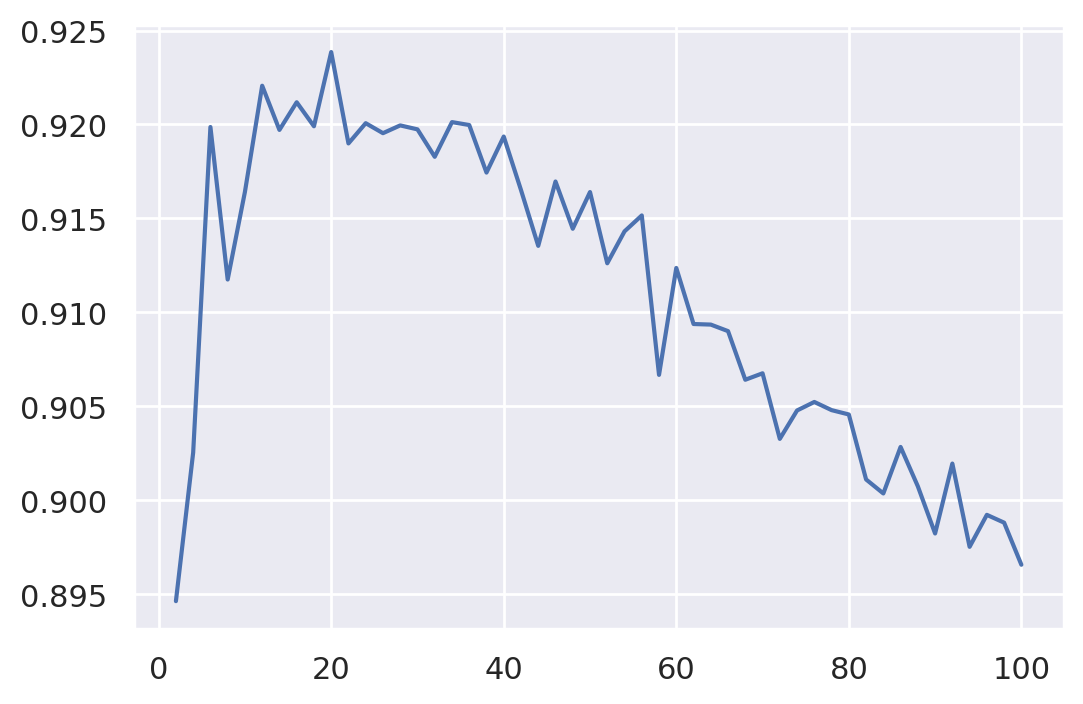

In [166]:
plt.plot(component_range, result)

print("Best -> {}:{:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [ ]:
y_true = np.concatenate((np.zeros(len(inlier_score)),
                         np.ones(len(outlier_score))))
y_scores = np.concatenate((inlier_score, outlier_score))


roc_auc = roc_auc_score(y_true,y_scores)

In [151]:
metrics(-test_score, -np.concatenate((outlier_score, outlier_score_2)), plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9197
PR-AUC: 0.9564
Avg Prec: 0.9564


**CIFAR vs CelebA**

In [146]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.8493
PR-AUC: 0.7716
Avg Prec: 0.7724


**CIFAR vs SVHN**

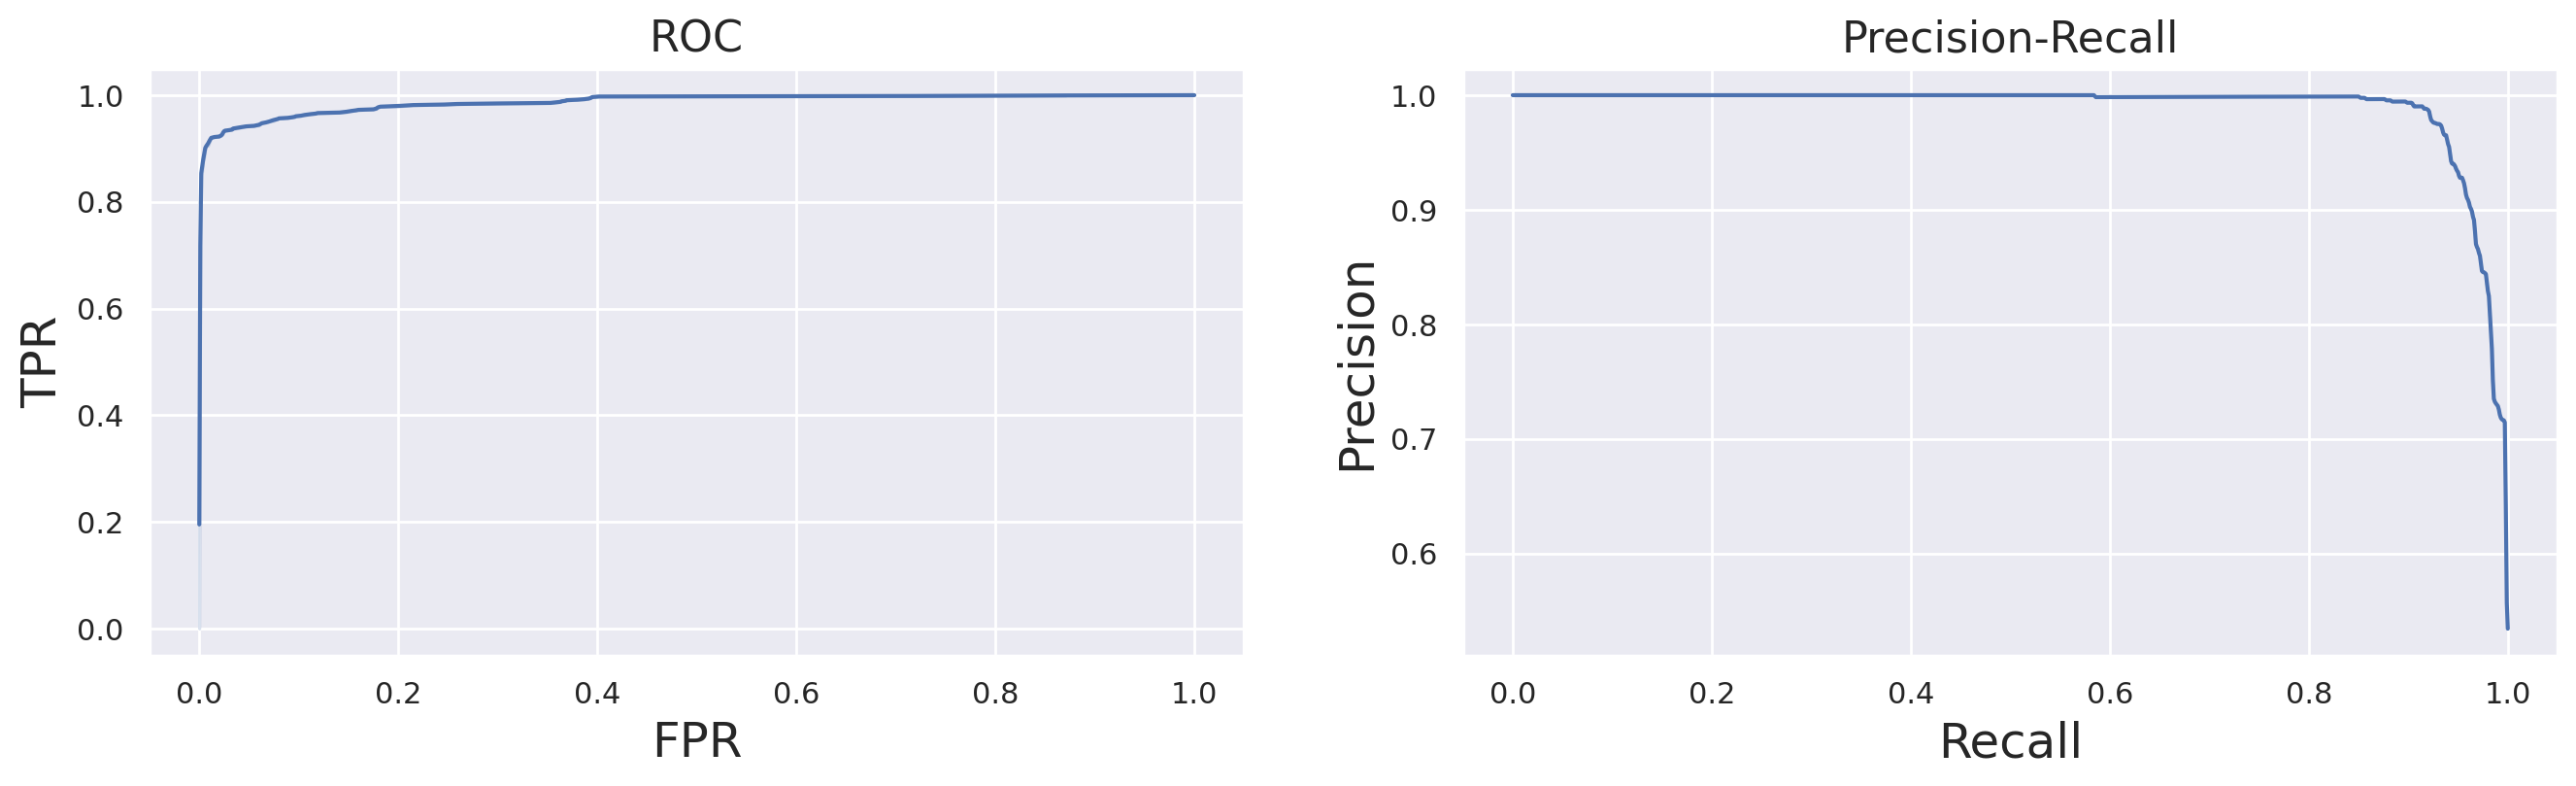

Inlier vs Outlier
----------------
ROC-AUC: 0.9868
PR-AUC: 0.9893
Avg Prec: 0.9893


In [119]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()